First watch the explanations:

https://www.youtube.com/watch?v=R39tWYYKNcI&list=PLkDaE6sCZn6Gl29AoE31iwdVwSG-KnDzF&index=38

https://www.youtube.com/watch?v=ChoV5h7tw5A&list=PLkDaE6sCZn6Gl29AoE31iwdVwSG-KnDzF&index=38

https://www.youtube.com/watch?v=xY-DMAJpIP4&list=PLkDaE6sCZn6Gl29AoE31iwdVwSG-KnDzF&index=39

https://www.youtube.com/watch?v=b1I5X3UfEYI&list=PLkDaE6sCZn6Gl29AoE31iwdVwSG-KnDzF&index=40

https://www.youtube.com/watch?v=QgkLfjfGul8&list=PLkDaE6sCZn6Gl29AoE31iwdVwSG-KnDzF&index=41

The algorithm is simple:

1. Pass the input image through a pre-trained model.
2. Extract the layer values at pre-defined layers.
3. Pass the generated image (initially this is just copy of content image) through the model and extract its values at the
same pre-defined layers.
4. Calculate the content loss at each layer corresponding to the content image
and generated image.
5. Pass the style image through multiple layers of the model and calculate the
gram matrix values of the style image.
6. Pass the generated image through the same layers that the style image is
passed through and calculate its corresponding gram matrix values.
7. Extract the squared difference of the gram matrix values of the two images.
This is the style loss.
8. The overall loss is the weighted average of the style loss and content
loss.
9. The input image that minimizes the overall loss is the final image.

In [ ]:
!pip install torch_snippets
from torch_snippets import *
from torchvision import transforms as T
from torch.nn import functional as F
import requests

from torchvision.models import vgg19

In [ ]:
# img_data = requests.get('https://1drv.ms/u/s!AhnVhbVlzYkKdxpQSrXZhZE02_M?e=jGfd9W').content
# with open('content_image.JPG', 'wb') as handler:
#     handler.write(img_data)

# img_data = requests.get('https://1drv.ms/u/s!AhnVhbVlzYkKeOPHmN3mCPTgg3s').content
# with open('style_image.PNG', 'wb') as handler:
#     handler.write(img_data)

# you can generally use this only if the url is just image ending something.png, something.jpg etc
# !wget https://1drv.ms/u/s!AhnVhbVlzYkKdxpQSrXZhZE02_M?e=jGfd9W -O content_image.jpg 
# !wget https://1drv.ms/u/s!AhnVhbVlzYkKeOPHmN3mCPTgg3s -O style_image.png

# here you have to use one drive sdk or download images from one drive and upload in google colab

In [ ]:
# for best result create this statistics according to your data

preprocess = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    T.Lambda(lambda x: x.mul_(255))
])
postprocess = T.Compose([
    T.Lambda(lambda x: x.mul_(1./255)),
    T.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], std=[1/0.229, 1/0.224, 1/0.225]),
])

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

imgs = [Image.open(path).resize((512,512)).convert('RGB') for path in ['style_image.PNG', 'content_image.JPG']]
style_image, content_image = [preprocess(img).to(device)[None] for img in imgs]

opt_img = content_image.data.clone()
opt_img.requires_grad = True

In [ ]:
class GramMatrix(nn.Module):
    def forward(self, input):
        b,c,h,w = input.size()
        feat = input.view(b, c, h*w)
        G = feat@feat.transpose(1,2)     #gram matrix, basically just unnormalized multiple covariotion
        G.div_(h*w)
        return G
class GramMSELoss(nn.Module):
    def forward(self, input, target):
        out = F.mse_loss(GramMatrix()(input), target)
        return(out)
class vgg19_modified(nn.Module):
    def __init__(self):
        super().__init__()
        features = list(vgg19(pretrained = True).features)
        self.features = nn.ModuleList(features).eval() 
    def forward(self, x, layers=[]):
        order = np.argsort(layers)
        _results, results = [], []
        for ix, model in enumerate(self.features):
            x = model(x)
            if ix in layers: _results.append(x)
        for o in order: results.append(_results[o])
        return results if layers is not [] else x


In [ ]:
vgg = vgg19_modified().to(device)

style_layers = [0, 5, 10, 19, 28]     #which layers we want to use for style transfer learning
content_layers = [21]                 #layers we use for content learning
loss_layers = style_layers + content_layers

loss_fns = [GramMSELoss()] * len(style_layers) + [nn.MSELoss()] * len(content_layers)
loss_fns = [loss_fn.to(device) for loss_fn in loss_fns]

style_weights = [1000/n**2 for n in [64,128,256,512,512]] 
content_weights = [1]
weights = style_weights + content_weights

style_targets = [GramMatrix()(A).detach() for A in vgg(style_image, style_layers)]
content_targets = [A.detach() for A in vgg(content_image, content_layers)]
targets = style_targets + content_targets

max_iters = 100     #best is at least up to 400
optimizer = optim.LBFGS([opt_img])   # impements limited-memory Broyden–Fletcher–Goldfarb–Shanno algorithm
log = Report(max_iters)              # remember initially opt_img is content_images copy

In [ ]:
iters = 0
while iters < max_iters:
    def closure():
        global iters
        iters += 1
        optimizer.zero_grad()
        out = vgg(opt_img, loss_layers)
        layer_losses = [weights[a] * loss_fns[a](A, targets[a]) for a,A in enumerate(out)]
        loss = sum(layer_losses)
        loss.backward()
        log.record(pos=iters, loss=loss, end='\r')
        return loss
    optimizer.step(closure)

EPOCH: 100.000	loss: 1577789.625	(1223.53s - 0.00s remaining)

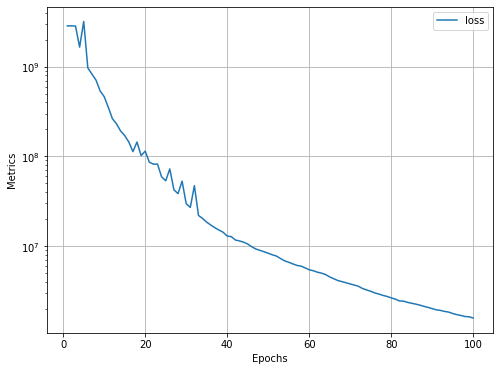

In [ ]:
log.plot(log=True)

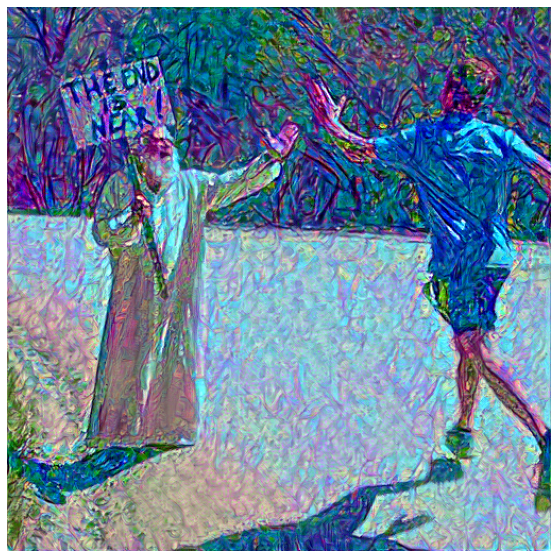

In [ ]:
with torch.no_grad():
    out_img = postprocess(opt_img[0]).permute(1,2,0)
show(out_img)